In [1]:
!nvidia-smi

Mon Mar 29 07:53:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# auxillary installation

In [2]:
!pip install -q timm
!pip install -q openpyxl

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# libararies 

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import sys 
from tqdm.notebook import tqdm 
import seaborn as sns 
import plotly
import random 
from glob import glob

import time
import cv2 
from PIL import Image
import imageio
from sklearn.utils import shuffle

from sklearn.metrics import roc_auc_score,f1_score ,accuracy_score , precision_score , f1_score , recall_score
from sklearn.model_selection import StratifiedKFold ,GroupKFold , train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
import albumentations 
from albumentations import *

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import gc
import timm
import sys
import warnings
import wandb
warnings.filterwarnings("ignore")
#wandb.login()

# config

In [4]:
cfg = {
    'fold':5,
    'seed':2021,
    'epochs':25,
    'train_bs':44,
    'valid_bs':44,
    'num_workers':8,
    'backbone': "resnet200d",
    'base_lr':1e-3,
    'patience':5,
    'test_bs':16,
    'min_lr':1e-9,
    'optimizer':'adam',
    'image_size':256,
    'use_amp': True
}

device = ('cuda' if torch.cuda.is_available() else 'cpu')

# data loading


# a. Covid data loading 

In [5]:
covid_images1 = pd.read_csv('../input/covid-chest-xray/metadata.csv')
covid_path = []
for i in range(covid_images1.shape[0]):
    if covid_images1['finding'][i] == 'COVID-19':
        covid_path.append(covid_images1['filename'][i])
for i in range(len(covid_path)):
    covid_path[i] = '../input/covid-chest-xray/images/'+covid_path[i]
covid1 = pd.DataFrame()
covid1['PATH']=covid_path
covid1['FILE NAME'] = 'Covid'
covid1['SIZE'] = '256*256'
for i in range(covid1.shape[0]):
    if covid1['PATH'][i].endswith('gz'):
        covid1= covid1.drop(labels = i,axis = 0)
covid2 = pd.read_excel('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx',engine = 'openpyxl')
covid2 = covid2.drop(['FORMAT'],axis = 1)
covid2 = covid2.rename(columns = {'URL':'PATH'})
for i in range(covid2.shape[0]):
    if covid2['FILE NAME'][i].startswith('COVID-'):
        name = covid2['FILE NAME'][i]
        covid2['PATH'][i] = f'../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/{name}.png'

covid2['FILE NAME'] = 'Covid'
covid = pd.concat([covid1,covid2],axis = 0).reset_index(drop = True)
covid

PATH FILE NAME     SIZE
0     ../input/covid-chest-xray/images/auntminnie-a-...     Covid  256*256
1     ../input/covid-chest-xray/images/auntminnie-b-...     Covid  256*256
2     ../input/covid-chest-xray/images/auntminnie-c-...     Covid  256*256
3     ../input/covid-chest-xray/images/auntminnie-d-...     Covid  256*256
4     ../input/covid-chest-xray/images/nejmc2001573_...     Covid  256*256
...                                                 ...       ...      ...
3886  ../input/covid19-radiography-database/COVID-19...     Covid  256*256
3887  ../input/covid19-radiography-database/COVID-19...     Covid  256*256
3888  ../input/covid19-radiography-database/COVID-19...     Covid  256*256
3889  ../input/covid19-radiography-database/COVID-19...     Covid  256*256
3890  ../input/covid19-radiography-database/COVID-19...     Covid  256*256

[3891 rows x 3 columns]

# b. Normal data loading 

In [6]:
normal1 = pd.DataFrame()
normal_path1 = glob('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/*jpeg')
normal1['PATH'] = normal_path1
normal1['FILE NAME'] = 'Normal'
normal1['SIZE'] = '1024*1024'

normal2 = pd.DataFrame()
normal_path2 = glob('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/*jpeg')
normal2['PATH'] = normal_path2
normal2['FILE NAME'] = 'Normal'
normal2['SIZE'] = '1024*1024'
normal3_ = pd.DataFrame()
normal3 = glob('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/*')
normal3_['PATH'] = normal3
normal3_['FILE NAME'] = 'Normal'
normal3_['SIZE'] = '1024*1024'
normal = pd.concat([normal1,normal2,normal3_],axis=0).reset_index(drop = True)
normal

PATH FILE NAME       SIZE
0      ../input/chest-xray-pneumonia/chest_xray/train...    Normal  1024*1024
1      ../input/chest-xray-pneumonia/chest_xray/train...    Normal  1024*1024
2      ../input/chest-xray-pneumonia/chest_xray/train...    Normal  1024*1024
3      ../input/chest-xray-pneumonia/chest_xray/train...    Normal  1024*1024
4      ../input/chest-xray-pneumonia/chest_xray/train...    Normal  1024*1024
...                                                  ...       ...        ...
11762  ../input/covid19-radiography-database/COVID-19...    Normal  1024*1024
11763  ../input/covid19-radiography-database/COVID-19...    Normal  1024*1024
11764  ../input/covid19-radiography-database/COVID-19...    Normal  1024*1024
11765  ../input/covid19-radiography-database/COVID-19...    Normal  1024*1024
11766  ../input/covid19-radiography-database/COVID-19...    Normal  1024*1024

[11767 rows x 3 columns]

# c. Pneumonia data loading  

In [7]:
pneumonia1 = pd.DataFrame()
pneumonia_path1 = glob('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*jpeg')
pneumonia1['PATH'] = pneumonia_path1
pneumonia1['FILE NAME'] = 'Pneumonia'
pneumonia1['SIZE'] = '1024*1024'

pneumonia2 = pd.DataFrame()
pneumonia_path2 = glob('../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/*jpeg')
pneumonia2['PATH'] = pneumonia_path2
pneumonia2['FILE NAME'] = 'Pneumonia'
pneumonia2['SIZE'] = '1024*1024'

pneumonia3 = pd.DataFrame()
pne3 = glob('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/*')
pneumonia3['PATH'] = pne3
pneumonia3['FILE NAME'] = 'Pneumonia'
pneumonia3['SIZE'] = '1024*1024'

pneumonia = pd.concat([pneumonia1,pneumonia2,pneumonia3],axis = 0).reset_index(drop = True)
pneumonia


PATH  FILE NAME       SIZE
0     ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia  1024*1024
1     ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia  1024*1024
2     ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia  1024*1024
3     ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia  1024*1024
4     ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia  1024*1024
...                                                 ...        ...        ...
5605  ../input/covid19-radiography-database/COVID-19...  Pneumonia  1024*1024
5606  ../input/covid19-radiography-database/COVID-19...  Pneumonia  1024*1024
5607  ../input/covid19-radiography-database/COVID-19...  Pneumonia  1024*1024
5608  ../input/covid19-radiography-database/COVID-19...  Pneumonia  1024*1024
5609  ../input/covid19-radiography-database/COVID-19...  Pneumonia  1024*1024

[5610 rows x 3 columns]

# d. Merging all the classes

In [8]:
data = pd.concat([covid,pneumonia,normal],axis = 0).reset_index(drop = True)
data = shuffle(data).reset_index(drop = True)
data

PATH  FILE NAME       SIZE
0      ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia  1024*1024
1      ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia  1024*1024
2      ../input/covid19-radiography-database/COVID-19...     Normal  1024*1024
3      ../input/covid19-radiography-database/COVID-19...      Covid    256*256
4      ../input/covid19-radiography-database/COVID-19...     Normal  1024*1024
...                                                  ...        ...        ...
21263  ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia  1024*1024
21264  ../input/covid-chest-xray/images/covid-19-pneu...      Covid    256*256
21265  ../input/covid19-radiography-database/COVID-19...      Covid    256*256
21266  ../input/covid19-radiography-database/COVID-19...     Normal  1024*1024
21267  ../input/covid19-radiography-database/COVID-19...      Covid    256*256

[21268 rows x 3 columns]

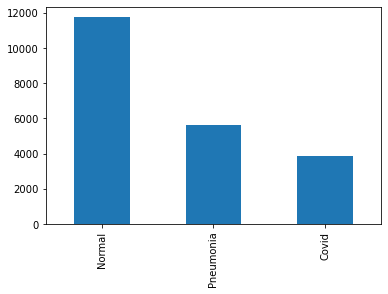

In [9]:
data['FILE NAME'].value_counts().plot(kind = 'bar')

# Helper function 

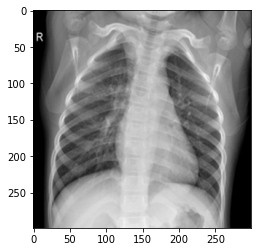

In [10]:
def plotter(imgs,cols = 3 , cmap = 'inferno',size=10, is_rgb=True,title = ''):
    rows = len(imgs)// cols+1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title,fontsize=30)

def load_images(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

img = load_images('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-100.png')
plt.imshow(img,cmap='gray')

# 1. Image data EDA

# lets take a look at covid images

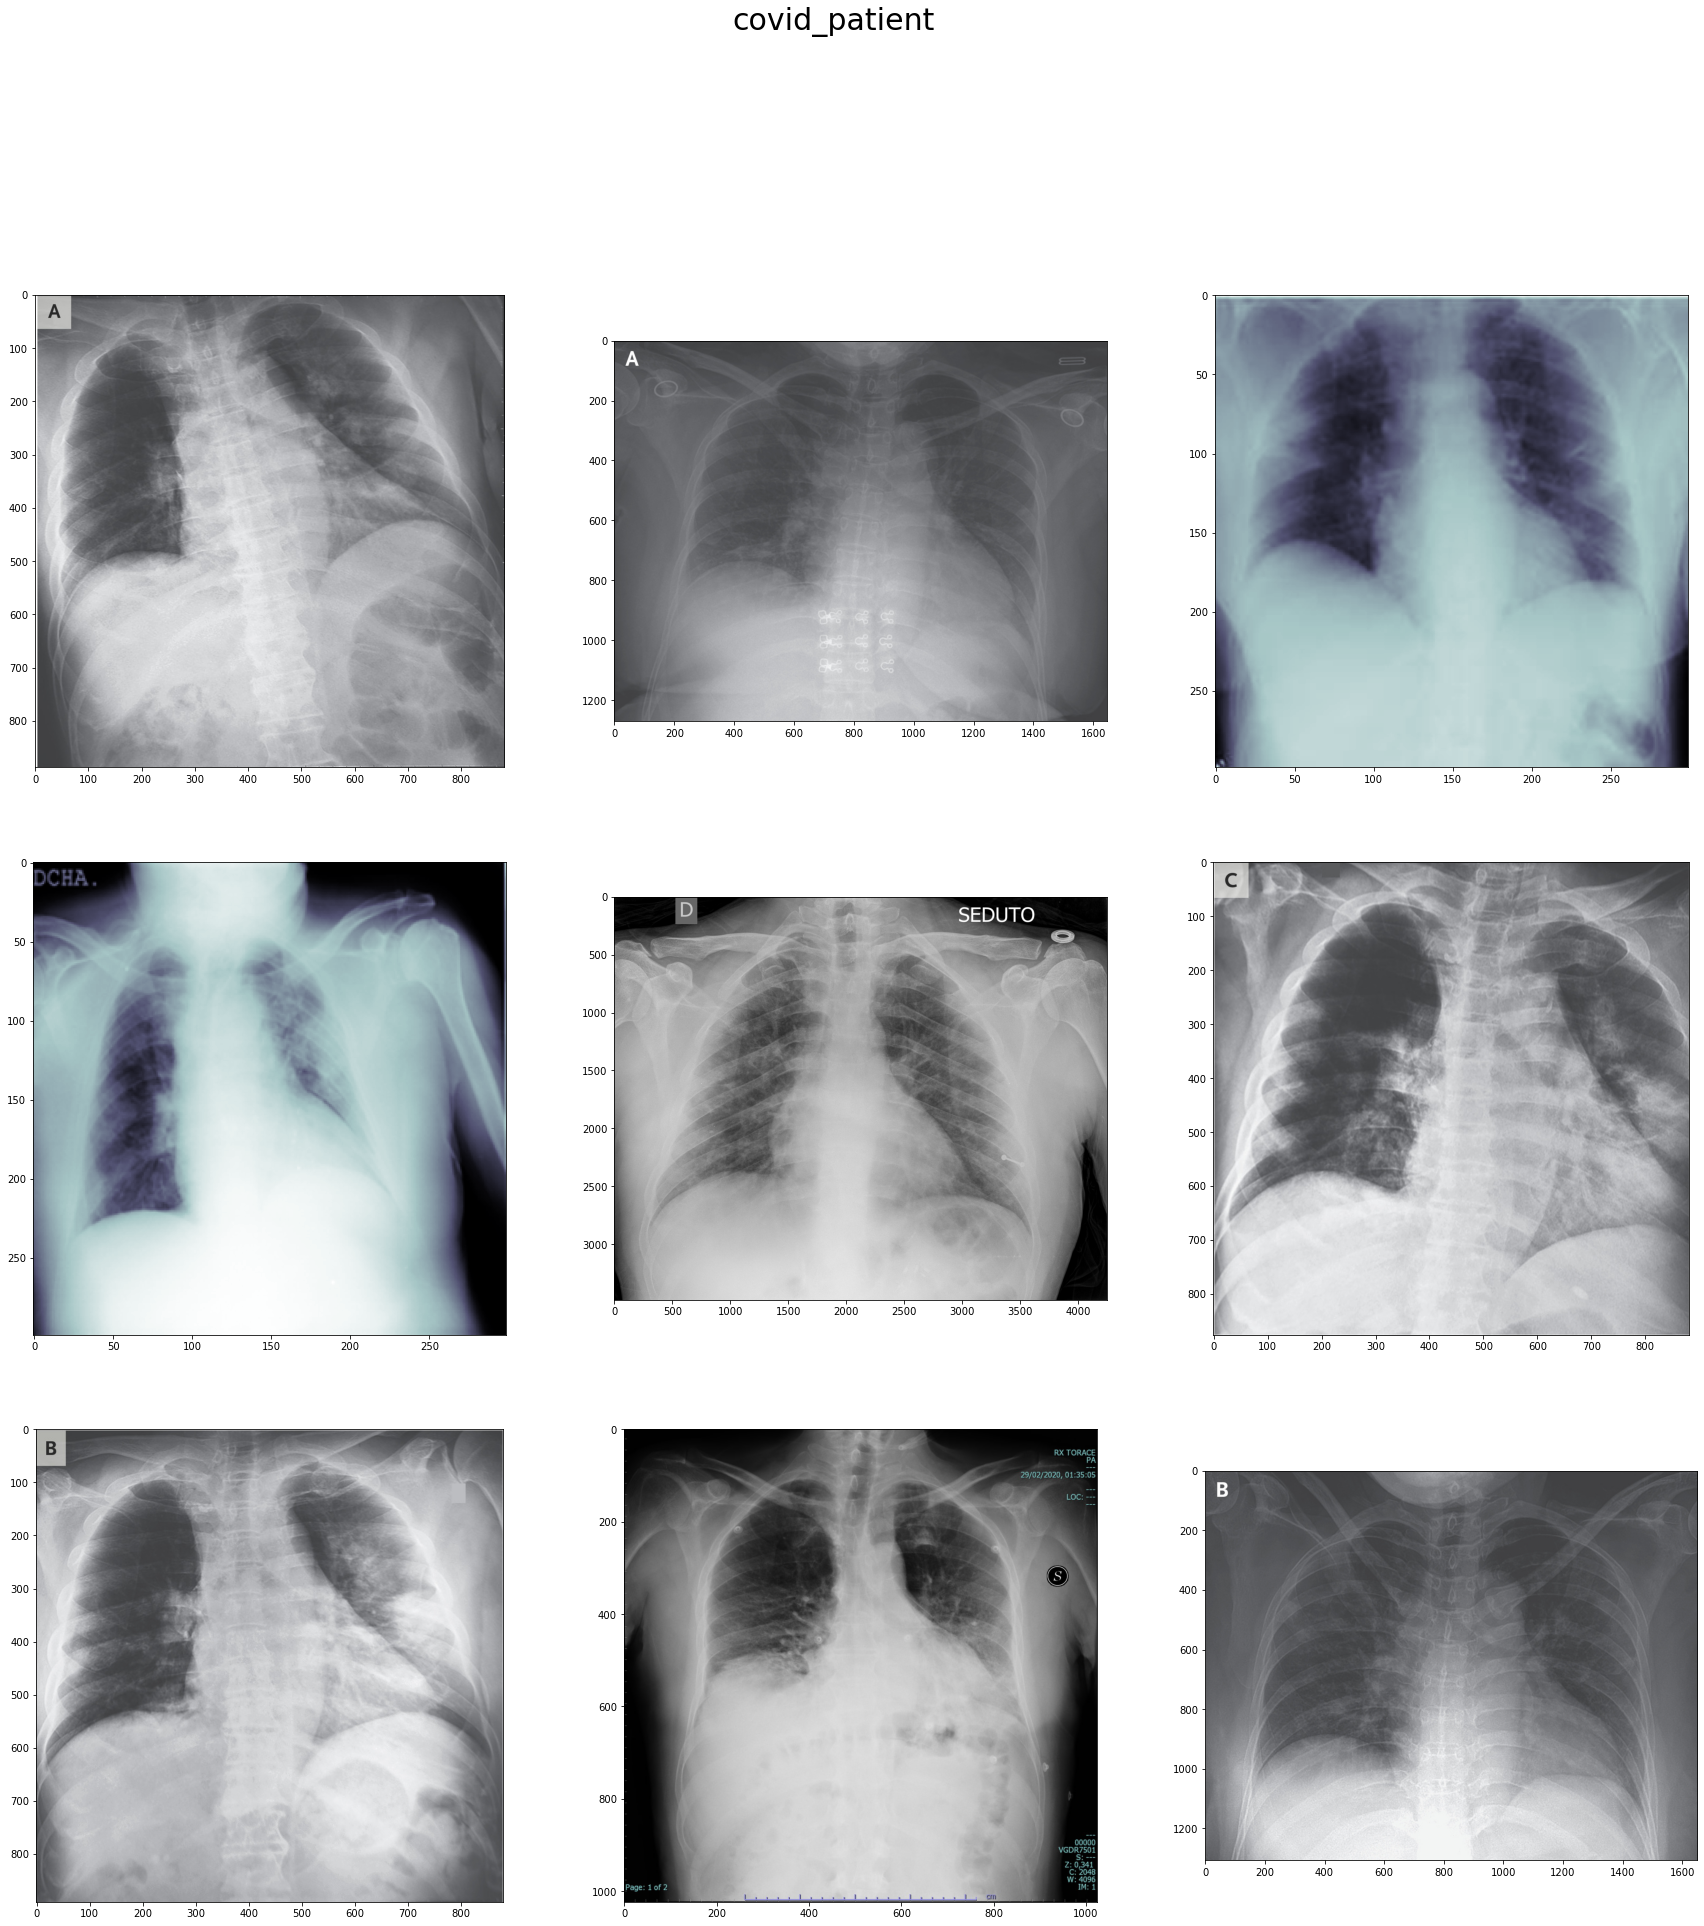

In [11]:
covid_path = [covid['PATH'][0],covid['PATH'][4],covid['PATH'][320],covid['PATH'][450],covid['PATH'][50]
              ,covid['PATH'][2],covid['PATH'][1],covid['PATH'][110]
             ,covid['PATH'][5]]

covid_images = []
for p in covid_path:
    covid_images.append(plt.imread(p))
plotter(covid_images ,title = 'covid_patient',cmap = 'bone')

# Now viral pneumonia images

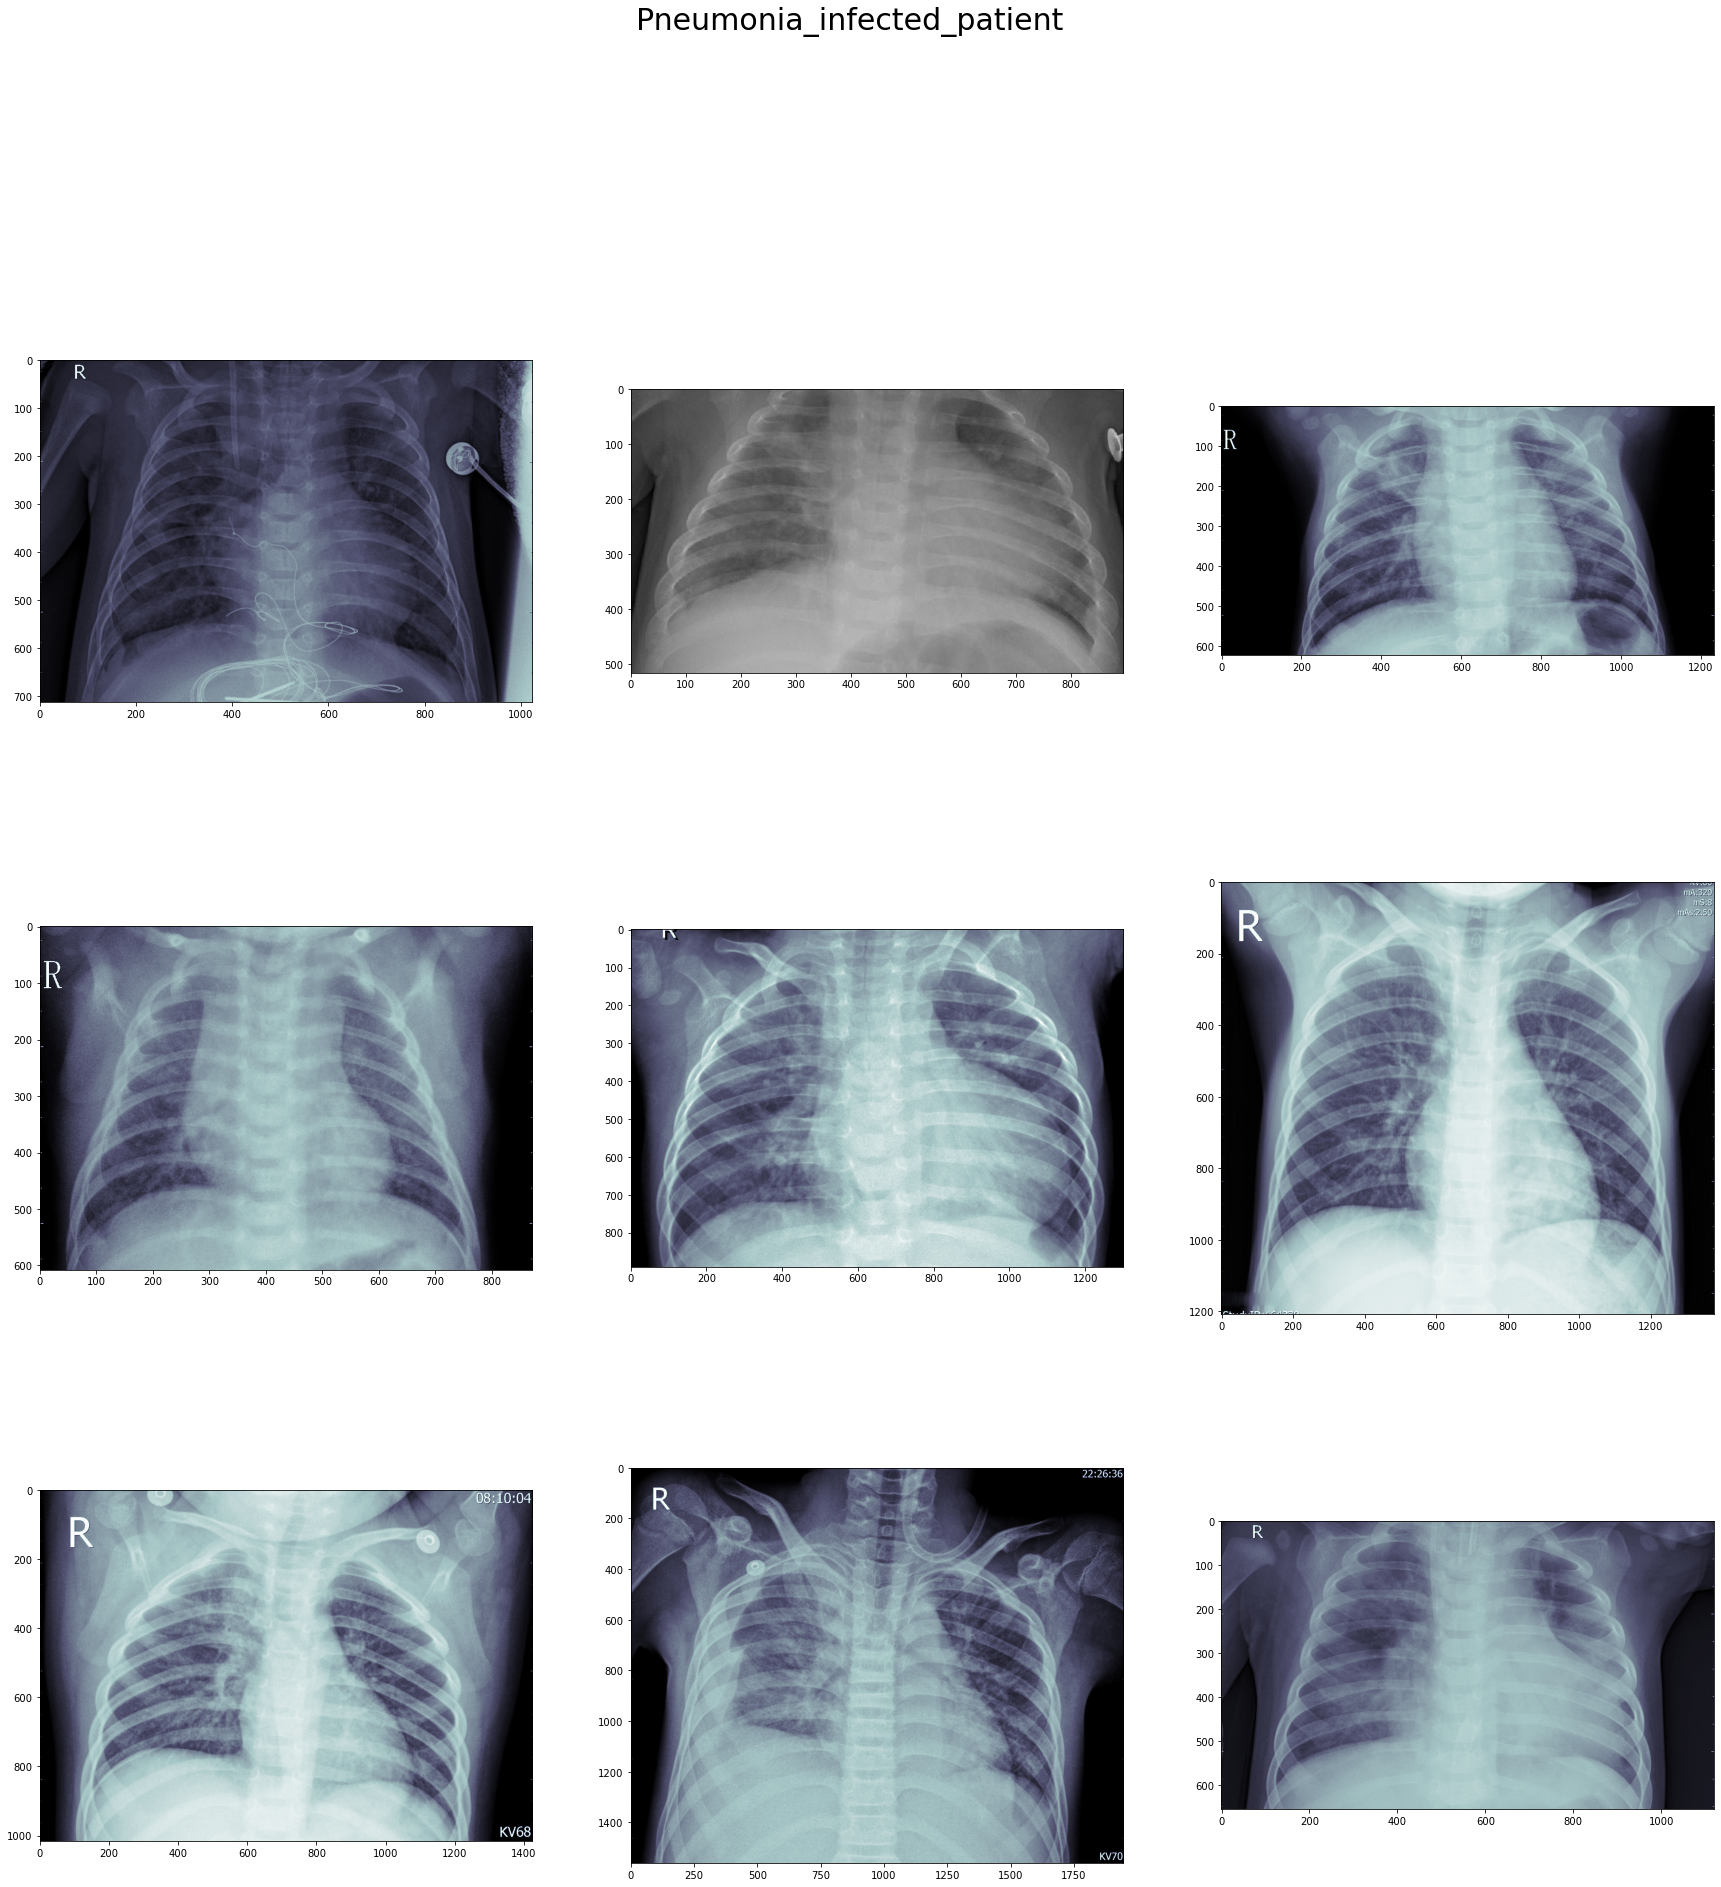

In [12]:
pne_patient_path = [pneumonia['PATH'][0],pneumonia['PATH'][4],pneumonia['PATH'][320],pneumonia['PATH'][450],pneumonia['PATH'][50]
              ,pneumonia['PATH'][2],pneumonia['PATH'][1],pneumonia['PATH'][110]
             ,pneumonia['PATH'][5]]
pneu_images = []
for p in pne_patient_path:
    pneu_images.append(plt.imread(p))
plotter(pneu_images,title = 'Pneumonia_infected_patient',cmap = 'bone')

# Now the normal images

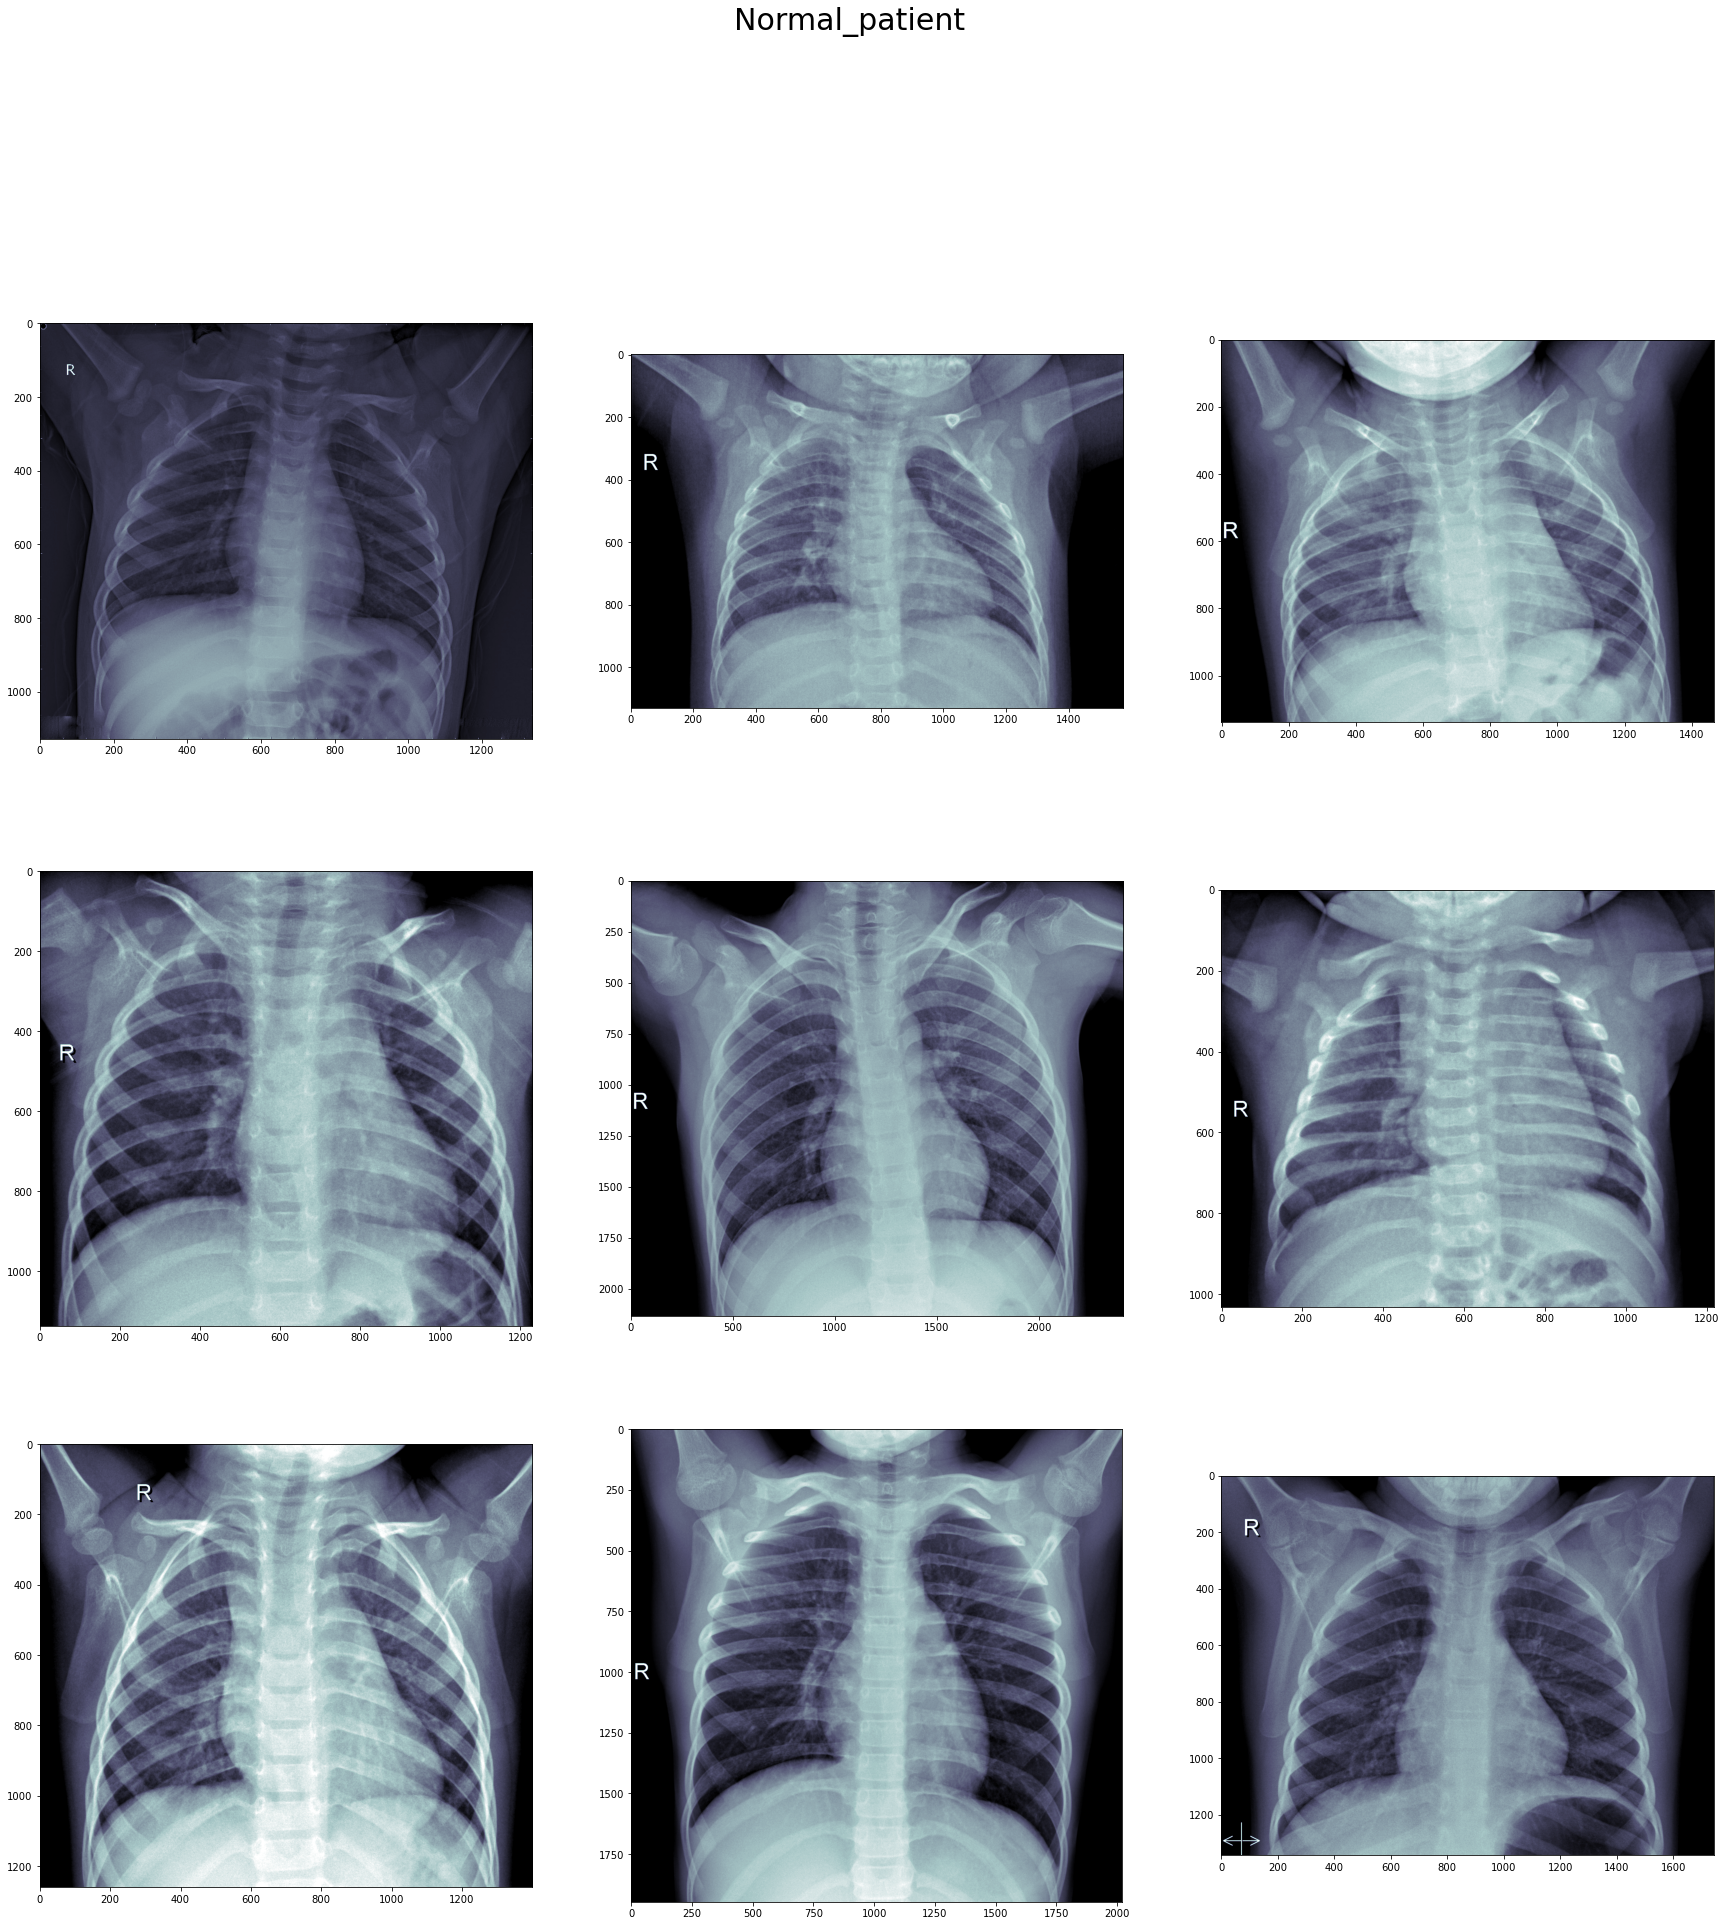

In [13]:
normal_patient_path = [normal['PATH'][0],normal['PATH'][4],normal['PATH'][320],normal['PATH'][450],normal['PATH'][50]
              ,normal['PATH'][2],normal['PATH'][1],normal['PATH'][110]
             ,normal['PATH'][5]]
normal_images = []
for p in normal_patient_path:
    normal_images.append(plt.imread(p))
plotter(normal_images,title = 'Normal_patient',cmap = 'bone')

# Tabular data EDA

In [14]:
data

PATH  FILE NAME       SIZE
0      ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia  1024*1024
1      ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia  1024*1024
2      ../input/covid19-radiography-database/COVID-19...     Normal  1024*1024
3      ../input/covid19-radiography-database/COVID-19...      Covid    256*256
4      ../input/covid19-radiography-database/COVID-19...     Normal  1024*1024
...                                                  ...        ...        ...
21263  ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia  1024*1024
21264  ../input/covid-chest-xray/images/covid-19-pneu...      Covid    256*256
21265  ../input/covid19-radiography-database/COVID-19...      Covid    256*256
21266  ../input/covid19-radiography-database/COVID-19...     Normal  1024*1024
21267  ../input/covid19-radiography-database/COVID-19...      Covid    256*256

[21268 rows x 3 columns]

1. from looking above in the data frame we found that there is no class section indeed it has File Name which tells what class the image belongs to hence we will have to fix that first
2. And as we look more in the dataset there is no other tabular data that will be helful for the model hence it will be a classic Computer Vision problem , unlike tabular + image model 

In [15]:
#train = train.loc[:10000,:]
data = data.rename(columns = {'FILE NAME':'Class'})
#px.bar(data,x ='Class',title = 'Class distribution vs Image size available', color = 'SIZE')

from looking at the bargraph we can see that the data is highly imbalanced and we also found out that we have covid images of size 256 by 256 pixels and normal and pneumonia images of size 1024 by 1024 pixels

In [16]:
# setting up labels / targets

data['Targets'] = 0

for i in range(data.shape[0]):
    if data['Class'][i] == 'Covid':
        data['Targets'][i] = 0
    elif data['Class'][i] == 'Pneumonia':
        data['Targets'][i] = 1
    elif data['Class'][i] == 'Normal':
        data['Targets'][i] = 2
data

PATH      Class  \
0      ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia   
1      ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia   
2      ../input/covid19-radiography-database/COVID-19...     Normal   
3      ../input/covid19-radiography-database/COVID-19...      Covid   
4      ../input/covid19-radiography-database/COVID-19...     Normal   
...                                                  ...        ...   
21263  ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia   
21264  ../input/covid-chest-xray/images/covid-19-pneu...      Covid   
21265  ../input/covid19-radiography-database/COVID-19...      Covid   
21266  ../input/covid19-radiography-database/COVID-19...     Normal   
21267  ../input/covid19-radiography-database/COVID-19...      Covid   

            SIZE  Targets  
0      1024*1024        1  
1      1024*1024        1  
2      1024*1024        2  
3        256*256        0  
4      1024*1024        2  
...          ...      ...  
21263  1024*1024        1  
21264    256*256        0  
21265    256*256        0  
21266  1024*1024        2  
21267    256*256        0  

[21268 rows x 4 columns]

# 3. Model build up 

# a. Setting up seeds 

In [17]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True # for faster training, but not deterministic

seed_everything(cfg['seed'])

# b. augmentations 

In [18]:
transforms_train = albumentations.Compose([
   albumentations.RandomResizedCrop(cfg['image_size'], cfg['image_size'], scale=(0.9, 1), p=1), 
   albumentations.HorizontalFlip(p=0.5),
   albumentations.ShiftScaleRotate(p=0.5),
   albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.5),
   albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.5),
   albumentations.CLAHE(clip_limit=(1,4), p=0.5),
   albumentations.OneOf([
       albumentations.OpticalDistortion(distort_limit=1.0),
       albumentations.GridDistortion(num_steps=5, distort_limit=1.),
       albumentations.ElasticTransform(alpha=3),
   ], p=0.2),
   albumentations.OneOf([
       albumentations.GaussNoise(var_limit=[10, 50]),
       albumentations.GaussianBlur(),
       albumentations.MotionBlur(),
       albumentations.MedianBlur(),
   ], p=0.2),
  albumentations.OneOf([
      JpegCompression(),
      Downscale(scale_min=0.1, scale_max=0.15),
  ], p=0.2),
  IAAPiecewiseAffine(p=0.2),
  IAASharpen(p=0.2),
  albumentations.Cutout(max_h_size=int(cfg['image_size'] * 0.1), max_w_size=int(cfg['image_size']* 0.1), num_holes=5, p=0.5),
  albumentations.Normalize(),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(cfg['image_size'], cfg['image_size']),
    albumentations.Normalize()
])

# c. Dataset

In [19]:
class covid_classifier_dataset(Dataset):
    def __init__(self,
                 df,
                augmentations = None
                ):
        super().__init__()
        self.df = df 
        self.augmentations  = augmentations 
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self,idx):
        label = self.df['Targets'][idx]
        img = cv2.imread(self.df['PATH'][idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentations  is not None:
            res = self.augmentations(image = img)
            img = res['image']
        img = img.astype(np.float32)
        img = img.transpose(2,0,1)
       # img = torch.tensor(img).float()
        
        return img,label
        

# d. Dataloader

In [20]:
def covid_dataloader(data,train_idx,valid_idx):
    train_ = data.iloc[train_idx,:].reset_index(drop = True)
    train_dataset = covid_classifier_dataset(train_,augmentations  = transforms_train )
    train_loader = DataLoader(train_dataset,batch_size = cfg['train_bs'],shuffle = True,
                              num_workers = cfg['num_workers'],pin_memory = False,
                              drop_last = False
                             )
    
    valid_ = data.iloc[valid_idx,:].reset_index(drop = True)
    valid_dataset = covid_classifier_dataset(valid_,augmentations  = transforms_valid)
    valid_loader = DataLoader(valid_dataset,batch_size = cfg['valid_bs'],shuffle = False,
                             num_workers = cfg['num_workers'],pin_memory = False)
    
    return train_loader , valid_loader

# f. Train one epoch 

In [21]:
def train_one_epoch(train_loader,model,optimizer,loss_fun,device,scheduler,epoch):
    model.train()
    t = time.time()
    losses = []
    image_preds_all = []
    image_targets_all = []
    loss = 0.0
    acc = 0.0
    accuracy = 0.0
    f1 = 0.0
    recall = 0.0
    precision = 0.0
    if  cfg['use_amp']:
        scaler = torch.cuda.amp.GradScaler()
    pbar = tqdm(enumerate(train_loader),total = len(train_loader))
    for step ,(images,labels) in pbar:
     #   labels = labels.unsqueeze(1)
        images, labels = images.to(device,dtype = torch.float32), labels.to(device,dtype = torch.long)
        PREDS = []
        TARGETS = []
        if cfg['use_amp']:
            with torch.cuda.amp.autocast():
                logits = model(images)
                image_preds_all += [torch.argmax(logits, 1).detach().cpu().numpy()]
                image_targets_all += [labels.detach().cpu().numpy()]
                PREDS.append(logits.detach().cpu().numpy())
                TARGETS.append(labels.detach().cpu().numpy())
                loss = loss_fun(logits,labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()
        
        else:
            logits = model(images)
            image_preds_all += [torch.argmax(logits, 1).detach().cpu().numpy()]
            image_targets_all += [labels.detach().cpu().numpy()]
            PREDS.append(logits.detach().cpu().numpy())
            TARGETS.append(labels.detach().cpu().numpy())
            loss = loss_fun(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        losses.append(loss.item())
        TARGETS = np.concatenate(TARGETS)
        PREDS = np.concatenate(PREDS)
        acc = np.mean(PREDS.argmax(axis=1) == TARGETS)
        pbar.set_description(f'E:{epoch} loss: {loss.item():.5f},acc :{acc:.3f}')
  
            
 
    losses = np.mean(losses) 
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    accuracy = accuracy_score(image_targets_all,image_preds_all)
    f1 = f1_score(image_targets_all,image_preds_all,average='macro')
    precision = precision_score(image_targets_all , image_preds_all,average='macro')
    recall = recall_score(image_targets_all , image_preds_all,average='macro')
   
  #  accuracy = (image_preds_all == image_targets_all).mean()
    return losses , accuracy  , f1 , precision , recall 
            
                
        

# g. Validate one epoch 

In [22]:
def validate_one_epoch(valid_loader,loss_fun,model,device,epoch):
    t = time.time()
    accuracy = 0.0
    loss = 0.0
    auc = 0.0
    f1 = 0.0
    recall = 0.0
    precision = 0.0
    losses = []
    image_preds_all = []
    image_targets_all = []
    pbar = tqdm(enumerate(valid_loader),total = len(valid_loader))
    for step , (images,labels) in pbar:
      #  labels = labels.unsqueeze(1)
        images , labels = images.to(device,dtype = torch.float32) , labels.to(device,dtype = torch.long)
        PREDS = []
        TARGETS = []
        with torch.no_grad():
            logits = model (images)
            image_preds_all += [torch.argmax(logits, 1).detach().cpu().numpy()]
            image_targets_all += [labels.detach().cpu().numpy()]
            PREDS.append(logits.detach().cpu().numpy())
            TARGETS.append(labels.detach().cpu().numpy())
            loss = loss_fun(logits,labels)
        losses.append(loss.item())
        TARGETS = np.concatenate(TARGETS)
        PREDS = np.concatenate(PREDS)
        acc = np.mean(PREDS.argmax(axis=1) == TARGETS)
        pbar.set_description(f'E:{epoch},loss: {loss.item():.5f},acc :{acc:.3f}')
      
    losses = np.mean(losses)
    image_preds_all  = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    accuracy = accuracy_score(image_targets_all,image_preds_all)
    f1 = f1_score(image_targets_all,image_preds_all,average='macro')
    precision = precision_score(image_targets_all , image_preds_all,average='macro')
    recall = recall_score(image_targets_all , image_preds_all,average='macro')
   # accuracy = (image_preds_all == image_targets_all).mean()
    return losses , accuracy ,f1 , precision , recall 
        
    

# Engine 

In [23]:
data

PATH      Class  \
0      ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia   
1      ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia   
2      ../input/covid19-radiography-database/COVID-19...     Normal   
3      ../input/covid19-radiography-database/COVID-19...      Covid   
4      ../input/covid19-radiography-database/COVID-19...     Normal   
...                                                  ...        ...   
21263  ../input/chest-xray-pneumonia/chest_xray/train...  Pneumonia   
21264  ../input/covid-chest-xray/images/covid-19-pneu...      Covid   
21265  ../input/covid19-radiography-database/COVID-19...      Covid   
21266  ../input/covid19-radiography-database/COVID-19...     Normal   
21267  ../input/covid19-radiography-database/COVID-19...      Covid   

            SIZE  Targets  
0      1024*1024        1  
1      1024*1024        1  
2      1024*1024        2  
3        256*256        0  
4      1024*1024        2  
...          ...      ...  
21263  1024*1024        1  
21264    256*256        0  
21265    256*256        0  
21266  1024*1024        2  
21267    256*256        0  

[21268 rows x 4 columns]

In [24]:
def engine(number_of_splits):
    folds = StratifiedKFold(n_splits = number_of_splits,random_state = cfg['seed'], shuffle = True).split(data['PATH'],data['Targets'])
    for fold,(train_idx,valid_idx) in enumerate(folds):
        if fold > 0:
            break
        print('Training with {} fold:{} started'.format(device,fold))
        print(f"We have {len(train_idx)} training images, and {len(valid_idx)} validation images")
        
        
        # model 
      #  model = my_model(cfg['backbone'],3,pretrained = True)
        model = timm.create_model(cfg['backbone'], pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 3)
        model = model.to(device)
        
        # loss_function 
       # loss_fun = nn.BCEWithLogitsLoss()
        loss_fun= nn.CrossEntropyLoss()
       # loss_fun = nn.NLLLoss()
        # loss_fun = nn.LogSoftmax()
       # loss_fun = nn.BCELoss()
        
        # wandb 
   #     wandb.init(project=""+f"covid19_classifier_{fold}", config=cfg)
   #     wandb.watch(model, loss_fun, log="all", log_freq=10)
   #     log = {}
    
        # optimizer 
        optimizer = torch.optim.Adam(model.parameters(),lr = cfg['base_lr'])
        
        # scheduler 
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10)
        
        # train_loader , valid_loader
        train_loader,valid_loader = covid_dataloader(data,train_idx,valid_idx)
        
        # parameters 
        f1_threshold = 0.92
        validation = 0.0
        
        
        for epoch in range(cfg['epochs']):
            
            # training 
            train_loss , train_accuracy  ,train_f1_score , train_precision , train_recall  = train_one_epoch(train_loader,model,optimizer,loss_fun,device,scheduler,epoch)
            print(f'Epoch: {epoch} Train loss : {train_loss} , Train_accuracy :{train_accuracy} , train_precision :{train_precision} , train_recall:{train_recall} , train_f1_score:{train_f1_score}')
       #     wandb.log({"train_loss": train_loss})
       #     wandb.log({'train_accuracy':train_accuracy})
       #     wandb.log({"train_precision": train_precision})
       #     wandb.log({'train_recall':train_recall})
       #     wandb.log({'train_f1_score':train_f1_score})
            
            
            
            
            # validating 
            valid_loss , valid_accuracy ,valid_f1_score , valid_precision , valid_recall = validate_one_epoch(valid_loader,loss_fun,model ,device,epoch)
            print(f'Epoch: {epoch} Valid loss : {valid_loss} , valid_accuracy : {valid_accuracy} valid_precision :{valid_precision} , valid_recall:{valid_recall} , valid_f1_score:{valid_f1_score}')
       #     wandb.log({"valid_loss": valid_loss})
       #     wandb.log({"valid_accuracy": valid_accuracy})
       #     wandb.log({"valid_precision": valid_precision})
       #     wandb.log({'valid_recall':valid_recall})
       #     wandb.log({'valid_f1_score':valid_f1_score})
            backbone = cfg['backbone']
            
            if valid_f1_score > validation:
                print(f'Validation f1 score improved from {validation} to {valid_f1_score}')
                validation = valid_f1_score
                if validation > f1_threshold:
                    print('validation beat our threshold hence saving the model weights ')
                    torch.save(model.state_dict(),f'Covid_classifier_{backbone}_fold{fold}_validf1{validation}.pth')
            
        torch.save(model.state_dict(),f'Covid_classifier_{backbone}_final.pth')

# lets run the engine 


In [25]:
engine(cfg['fold'])

Training with cuda fold:0 started
We have 17014 training images, and 4254 validation images


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet200d_ra2-bdba9bf9.pth" to /root/.cache/torch/hub/checkpoints/resnet200d_ra2-bdba9bf9.pth



Epoch: 0 Train loss : 0.42051552673103887 , Train_accuracy :0.8316092629599153 , train_precision :0.8312832095644952 , train_recall:0.7817517469332079 , train_f1_score:0.8018178098547709



Epoch: 0 Valid loss : 0.14398155914446742 , valid_accuracy : 0.9518100611189468 valid_precision :0.9617219664856104 , valid_recall:0.9322740713551224 , valid_f1_score:0.9458412924749119
Validation f1 score improved from 0.0 to 0.9458412924749119
validation beat our threshold hence saving the model weights 



Epoch: 1 Train loss : 0.25941320435560333 , Train_accuracy :0.8968496532267545 , train_precision :0.8908655002302179 , train_recall:0.8713690879137093 , train_f1_score:0.8802363714914007



Epoch: 1 Valid loss : 0.09876909587033016 , valid_accuracy : 0.9682651622002821 valid_precision :0.9705750508573089 , valid_recall:0.9592227413687834 , valid_f1_score:0.9647012768110694
Validation f1 score improved from 0.9458412924749119 to 0.9647012768110694
validation beat our threshold hence saving the model weights 



Epoch: 2 Train loss : 0.2160424987282556 , Train_accuracy :0.9175384977077701 , train_precision :0.9127962709336271 , train_recall:0.8987531465929012 , train_f1_score:0.9053244416961101



Epoch: 2 Valid loss : 0.08972640715769886 , valid_accuracy : 0.9680300893276916 valid_precision :0.961201660718328 , valid_recall:0.9690402957629364 , valid_f1_score:0.9649184296929917
Validation f1 score improved from 0.9647012768110694 to 0.9649184296929917
validation beat our threshold hence saving the model weights 



Epoch: 3 Train loss : 0.19559063419738174 , Train_accuracy :0.925531914893617 , train_precision :0.9200956838021542 , train_recall:0.9086947682595011 , train_f1_score:0.9140788870430628



Epoch: 3 Valid loss : 0.0956754356661101 , valid_accuracy : 0.9659144334743771 valid_precision :0.9621821093060604 , valid_recall:0.9635087732371334 , valid_f1_score:0.9627882476228476



Epoch: 4 Train loss : 0.19103521623622233 , Train_accuracy :0.9269425179264136 , train_precision :0.9228572522992463 , train_recall:0.9114069812129141 , train_f1_score:0.9168770566540858



Epoch: 4 Valid loss : 0.07052540526600536 , valid_accuracy : 0.9736718382698637 valid_precision :0.9800755941480036 , valid_recall:0.9622517482100207 , valid_f1_score:0.9707336643814113
Validation f1 score improved from 0.9649184296929917 to 0.9707336643814113
validation beat our threshold hence saving the model weights 



Epoch: 5 Train loss : 0.17609189675028317 , Train_accuracy :0.9302339250029388 , train_precision :0.926700927623489 , train_recall:0.9158216249701514 , train_f1_score:0.9210324722274152



Epoch: 5 Valid loss : 0.0692699817873384 , valid_accuracy : 0.9779031499764927 valid_precision :0.9818892559232738 , valid_recall:0.969081822348752 , valid_f1_score:0.9751596033297139
Validation f1 score improved from 0.9707336643814113 to 0.9751596033297139
validation beat our threshold hence saving the model weights 



Epoch: 6 Train loss : 0.1689662195174192 , Train_accuracy :0.9341130833431291 , train_precision :0.9295943776759859 , train_recall:0.921128376113613 , train_f1_score:0.925211212864241



Epoch: 6 Valid loss : 0.07753553642824139 , valid_accuracy : 0.9727315467795017 valid_precision :0.9768343230386968 , valid_recall:0.962071338106364 , valid_f1_score:0.9687563319423166



Epoch: 7 Train loss : 0.15366799491204958 , Train_accuracy :0.9401669213588809 , train_precision :0.9363953433154514 , train_recall:0.9291267325770963 , train_f1_score:0.9326555857629462



Epoch: 7 Valid loss : 0.05369543245772725 , valid_accuracy : 0.9833098260460743 valid_precision :0.9866518569150148 , valid_recall:0.9780622213291651 , valid_f1_score:0.9822568828136413
Validation f1 score improved from 0.9751596033297139 to 0.9822568828136413
validation beat our threshold hence saving the model weights 



Epoch: 8 Train loss : 0.15770262281484998 , Train_accuracy :0.9412248736334783 , train_precision :0.9373194845117289 , train_recall:0.9284655759291552 , train_f1_score:0.932736541206066



Epoch: 8 Valid loss : 0.07676392971758836 , valid_accuracy : 0.9722614010343207 valid_precision :0.9804385683232882 , valid_recall:0.9568152486194123 , valid_f1_score:0.9676050733380496



Epoch: 9 Train loss : 0.14451659862096458 , Train_accuracy :0.9448101563418362 , train_precision :0.940893959523826 , train_recall:0.9338370157694241 , train_f1_score:0.9372544797975882



Epoch: 9 Valid loss : 0.05569309102774588 , valid_accuracy : 0.9811941701927598 valid_precision :0.984309407354485 , valid_recall:0.9747208871688974 , valid_f1_score:0.979382370992885



Epoch: 10 Train loss : 0.14447463998325574 , Train_accuracy :0.9464558598800987 , train_precision :0.943072466137204 , train_recall:0.9354104670164225 , train_f1_score:0.9391325236859785



Epoch: 10 Valid loss : 0.04766336002761556 , valid_accuracy : 0.9844851904090268 valid_precision :0.9863059494821331 , valid_recall:0.9808987840647374 , valid_f1_score:0.9835627386034721
Validation f1 score improved from 0.9822568828136413 to 0.9835627386034721
validation beat our threshold hence saving the model weights 



Epoch: 11 Train loss : 0.13954481487318834 , Train_accuracy :0.9482191136710943 , train_precision :0.944246393261615 , train_recall:0.938527905944793 , train_f1_score:0.9413240909358791



Epoch: 11 Valid loss : 0.048179605790922786 , valid_accuracy : 0.9821344616831218 valid_precision :0.9817239822795486 , valid_recall:0.9792790188145698 , valid_f1_score:0.9804662847059382



Epoch: 12 Train loss : 0.13062976526929118 , Train_accuracy :0.94863053955566 , train_precision :0.9452225400039177 , train_recall:0.9385572718983514 , train_f1_score:0.9418074606235963



Epoch: 12 Valid loss : 0.05211399970384142 , valid_accuracy : 0.9811941701927598 valid_precision :0.9841474116108305 , valid_recall:0.9732035465502964 , valid_f1_score:0.9784777497582932



Epoch: 13 Train loss : 0.1321958026990718 , Train_accuracy :0.949629716703891 , train_precision :0.946209076177599 , train_recall:0.9399804060254159 , train_f1_score:0.9430189839065308



Epoch: 13 Valid loss : 0.03983984351849433 , valid_accuracy : 0.9842501175364363 valid_precision :0.9880014962168943 , valid_recall:0.9789154791797562 , valid_f1_score:0.983345166663276



Epoch: 14 Train loss : 0.12316779492215978 , Train_accuracy :0.9526272481485836 , train_precision :0.9495796085632274 , train_recall:0.944152378263461 , train_f1_score:0.9467940716101343



Epoch: 14 Valid loss : 0.08099606110877597 , valid_accuracy : 0.9743770568876352 valid_precision :0.9831952300582779 , valid_recall:0.9638695363436067 , valid_f1_score:0.9730125038803376



Epoch: 15 Train loss : 0.1264108694411179 , Train_accuracy :0.9501586928411896 , train_precision :0.9468328144533483 , train_recall:0.9399089663430438 , train_f1_score:0.9432760545914105



Epoch: 15 Valid loss : 0.05756285214633441 , valid_accuracy : 0.9816643159379408 valid_precision :0.9866255682105901 , valid_recall:0.9729130603025268 , valid_f1_score:0.9794659912575768



Epoch: 16 Train loss : 0.11769927638397583 , Train_accuracy :0.9538027506759139 , train_precision :0.950126830431716 , train_recall:0.9451533363490215 , train_f1_score:0.947584548616609



Epoch: 16 Valid loss : 0.08758500845833998 , valid_accuracy : 0.9668547249647391 valid_precision :0.9793658385519995 , valid_recall:0.9533708046174993 , valid_f1_score:0.9653675397576903



Epoch: 17 Train loss : 0.12177344994470285 , Train_accuracy :0.9550370283296109 , train_precision :0.9533076988002261 , train_recall:0.9459944188877927 , train_f1_score:0.949567660124492



Epoch: 17 Valid loss : 0.04980353674294485 , valid_accuracy : 0.9844851904090268 valid_precision :0.9792741389623831 , valid_recall:0.985633071801494 , valid_f1_score:0.9823761808500028



Epoch: 18 Train loss : 0.11591096883952541 , Train_accuracy :0.956623956741507 , train_precision :0.9535838133591085 , train_recall:0.9491792254219465 , train_f1_score:0.951338865259908



Epoch: 18 Valid loss : 0.040091482977642076 , valid_accuracy : 0.9884814292430654 valid_precision :0.9905374306819147 , valid_recall:0.9848957500687101 , valid_f1_score:0.9876722312005293
Validation f1 score improved from 0.9835627386034721 to 0.9876722312005293
validation beat our threshold hence saving the model weights 



Epoch: 19 Train loss : 0.11369730458048578 , Train_accuracy :0.95538967908781 , train_precision :0.9522458934470567 , train_recall:0.9468235854215191 , train_f1_score:0.9494752117035973



Epoch: 19 Valid loss : 0.05413941698288065 , valid_accuracy : 0.9797837329572168 valid_precision :0.985536811343155 , valid_recall:0.969831299422829 , valid_f1_score:0.9773233172178769



Epoch: 20 Train loss : 0.10594141619997123 , Train_accuracy :0.9583284354061361 , train_precision :0.9554229049815071 , train_recall:0.9504963579733537 , train_f1_score:0.9529099325955442



Epoch: 20 Valid loss : 0.036969928687784016 , valid_accuracy : 0.9877762106252939 valid_precision :0.9891836886478766 , valid_recall:0.9846505519245845 , valid_f1_score:0.9868892421383707



Epoch: 21 Train loss : 0.10694795500641106 , Train_accuracy :0.958210885153403 , train_precision :0.955591401182882 , train_recall:0.949696766864613 , train_f1_score:0.9525772746861122



Epoch: 21 Valid loss : 0.04523237959119328 , valid_accuracy : 0.9858956276445698 valid_precision :0.9881814639503803 , valid_recall:0.9807457680890215 , valid_f1_score:0.9843358239769818



Epoch: 22 Train loss : 0.10463122034430966 , Train_accuracy :0.9625602445045257 , train_precision :0.9594930708961263 , train_recall:0.9550329565642678 , train_f1_score:0.9572153203735286



Epoch: 22 Valid loss : 0.049269777136979644 , valid_accuracy : 0.9842501175364363 valid_precision :0.9894071328853937 , valid_recall:0.9770040571146011 , valid_f1_score:0.9829932056404562



Epoch: 23 Train loss : 0.10430204088484402 , Train_accuracy :0.9616198424826613 , train_precision :0.9586345021138255 , train_recall:0.9540510118095363 , train_f1_score:0.9563025071108777



Epoch: 23 Valid loss : 0.03752078944769179 , valid_accuracy : 0.9873060648801129 valid_precision :0.9853005941252233 , valid_recall:0.9873564322504459 , valid_f1_score:0.9863213383974033



Epoch: 24 Train loss : 0.10125390470668058 , Train_accuracy :0.9618549429881275 , train_precision :0.9593034855199655 , train_recall:0.9557950723898868 , train_f1_score:0.9575253484701767



Epoch: 24 Valid loss : 0.03488649330617975 , valid_accuracy : 0.9882463563704749 valid_precision :0.990078448640809 , valid_recall:0.985984641672744 , valid_f1_score:0.9879976498710269
Validation f1 score improved from 0.9876722312005293 to 0.9879976498710269
validation beat our threshold hence saving the model weights 


In [26]:
gc.collect()

4596